## Shaikat Islam 



## HW03 Code


You will complete the following notebook, as described in the PDF for Homework 03 (included in the download with the starter code).  You will submit:
1. This notebook file, along with your COLLABORATORS.txt file, to the Gradescope link for code.
2. A PDF of this notebook and all of its output, once it is completed, to the Gradescope link for the PDF.


Please report any questions to the [class Piazza page](https://piazza.com/class/k0grsypt15j73g).

### Import required libraries.

In [1]:
import os
import numpy as np
import pandas as pd

import sklearn.linear_model
import sklearn.tree
import sklearn.metrics

from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error

import seaborn as sns

## Part One: Cancer-Risk Screening

### 1.1: Compute true/false positives/negatives.

Complete the following code.

In [2]:
def calc_TP_TN_FP_FN(ytrue_N, yhat_N):
    ''' Compute counts of four possible outcomes of a binary classifier for evaluation.
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yhat_N : 1D array of floats
        Each entry represents a predicted binary value (either 0 or 1).
        One entry per example in current dataset.
        Needs to be same size as ytrue_N.

    Returns
    -------
    TP : float
        Number of true positives
    TN : float
        Number of true negatives
    FP : float
        Number of false positives
    FN : float
        Number of false negatives
    '''
    TP = 0.0
    TN = 0.0
    FP = 0.0
    FN = 0.0
    if (len(ytrue_N) != len(yhat_N)):
        print("Input vectors are not the same size.")
        return TP, TN, FP, FN
    else:
        for i in range(len(ytrue_N)):
            # 0 means negative
            # 1 means positive
            if (yhat_N[i] == ytrue_N[i] and ytrue_N[i] == 1):
                TP+=1
            elif (yhat_N[i] == ytrue_N[i] and ytrue_N[i] == 0):
                TN+=1
            elif (yhat_N[i] != ytrue_N[i] and yhat_N[i] == 1):
                FP+=1
            elif (yhat_N[i] != ytrue_N[i] and yhat_N[i] == 0):
                FN+=1
    return TP, TN, FP, FN

In [3]:
all0 = np.zeros(10)
all1 = np.ones(10)
calc_TP_TN_FP_FN(all0, all1)

(0.0, 0.0, 10.0, 0.0)

In [4]:
calc_TP_TN_FP_FN(all1, all0)

(0.0, 0.0, 0.0, 10.0)

In [5]:
calc_TP_TN_FP_FN(all1, all1)

(10.0, 0.0, 0.0, 0.0)

In [6]:
calc_TP_TN_FP_FN(all0, all0)

(0.0, 10.0, 0.0, 0.0)

### Supplied functions for later use

***Do not*** edit the following functions.  They are already complete, and will be used in your later code.

In [7]:
def calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Compute performance metrics for a given probabilistic classifier and threshold
    '''
    tp, tn, fp, fn = calc_TP_TN_FP_FN(ytrue_N, yproba1_N >= thresh)
    ## Compute ACC, TPR, TNR, etc.
    acc = (tp + tn) / float(tp + tn + fp + fn + 1e-10)
    tpr = tp / float(tp + fn + 1e-10)
    tnr = tn / float(fp + tn + 1e-10)
    ppv = tp / float(tp + fp + 1e-10)
    npv = tn / float(tn + fn + 1e-10)
    
    return acc, tpr, tnr, ppv, npv

def print_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Pretty print perf. metrics for a given probabilistic classifier and threshold
    '''
    acc, tpr, tnr, ppv, npv = calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh)
    
    ## Pretty print the results
    print("%.3f ACC" % acc)
    print("%.3f TPR" % tpr)
    print("%.3f TNR" % tnr)
    print("%.3f PPV" % ppv)
    print("%.3f NPV" % npv)

In [8]:
def calc_confusion_matrix_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Compute the confusion matrix for a given probabilistic classifier and threshold
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yproba1_N : 1D array of floats
        Each entry represents a probability (between 0 and 1) that correct label is positive (1)
        One entry per example in current dataset
        Needs to be same size as ytrue_N
    thresh : float
        Scalar threshold for converting probabilities into hard decisions
        Calls an example "positive" if yproba1 >= thresh

    Returns
    -------
    cm_df : Pandas DataFrame
        Can be printed like print(cm_df) to easily display results
    '''
    cm = sklearn.metrics.confusion_matrix(ytrue_N, yproba1_N >= thresh)
    cm_df = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
    cm_df.columns.name = 'Predicted'
    cm_df.index.name = 'True'
    return cm_df

In [9]:
def compute_perf_metrics_across_thresholds(ytrue_N, yproba1_N, thresh_grid=None):
    ''' Compute common binary classifier performance metrics across many thresholds
    
    If no array of thresholds is provided, will use all 'unique' values
    in the yproba1_N array to define all possible thresholds with different performance.
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yproba1_N : 1D array of floats
        Each entry represents a probability (between 0 and 1) that correct label is positive (1)
        One entry per example in current dataset

    Returns
    -------
    thresh_grid : 1D array of floats
        One entry for each possible threshold
    perf_dict : dict, with key, value pairs:
        * 'acc' : 1D array of accuracy values (one per threshold)
        * 'ppv' : 1D array of positive predictive values (one per threshold)
        * 'npv' : 1D array of negative predictive values (one per threshold)
        * 'tpr' : 1D array of true positive rates (one per threshold)
        * 'tnr' : 1D array of true negative rates (one per threshold)
    '''
    if thresh_grid is None:
        bin_edges = np.linspace(0, 1.001, 21)
        thresh_grid = np.sort(np.hstack([bin_edges, np.unique(yproba1_N)]))
    tpr_grid = np.zeros_like(thresh_grid)
    tnr_grid = np.zeros_like(thresh_grid)
    ppv_grid = np.zeros_like(thresh_grid)
    npv_grid = np.zeros_like(thresh_grid)
    acc_grid = np.zeros_like(thresh_grid)
    for tt, thresh in enumerate(thresh_grid):
        # Apply specific threshold to convert probas into hard binary values (0 or 1)
        # Then count number of true positives, true negatives, etc.
        # Then compute metrics like accuracy and true positive rate
        acc, tpr, tnr, ppv, npv = calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh)
        acc_grid[tt] = acc
        tpr_grid[tt] = tpr
        tnr_grid[tt] = tnr
        ppv_grid[tt] = ppv
        npv_grid[tt] = npv
    return thresh_grid, dict(
        acc=acc_grid,
        tpr=tpr_grid,
        tnr=tnr_grid,
        ppv=ppv_grid,
        npv=npv_grid)

def make_plot_perf_vs_threshold(ytrue_N, yproba1_N, bin_edges=np.linspace(0, 1, 21)):
    ''' Make pretty plot of binary classifier performance as threshold increases
    
    Produces a plot with 3 rows:
    * top row: hist of predicted probabilities for negative examples (shaded red)
    * middle row: hist of predicted probabilities for positive examples (shaded blue)
    * bottom row: line plots of metrics that require hard decisions (ACC, TPR, TNR, etc.)
    '''
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 8))
    sns.distplot(
        yproba1_N[ytrue_N == 0],
        color='r', bins=bin_edges, kde=False, rug=True, ax=axes[0]);
    sns.distplot(
        yproba1_N[ytrue_N == 1],
        color='b', bins=bin_edges, kde=False, rug=True, ax=axes[1]);

    thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(ytrue_N, yproba1_N)
    axes[2].plot(thresh_grid, perf_grid['acc'], 'k-', label='accuracy')
    axes[2].plot(thresh_grid, perf_grid['tpr'], 'b-', label='TPR (recall/sensitivity)')
    axes[2].plot(thresh_grid, perf_grid['tnr'], 'g-', label='TNR (specificity)')
    axes[2].plot(thresh_grid, perf_grid['ppv'], 'c-', label='PPV (precision)')
    axes[2].plot(thresh_grid, perf_grid['npv'], 'm-', label='NPV')
    
    axes[2].legend()
    axes[2].set_ylim([0, 1])

### Load the dataset.

The following should ***not*** be modified.  After it runs, the various arrays it creates will contain the 2- or 3-feature input datasets.

In [10]:
# Load 3 feature version of x arrays
x_tr_M3 = np.loadtxt('./data_cancer/x_train.csv', delimiter=',', skiprows=1)
x_va_N3 = np.loadtxt('./data_cancer/x_valid.csv', delimiter=',', skiprows=1)
x_te_N3 = np.loadtxt('./data_cancer/x_test.csv', delimiter=',', skiprows=1)

# 2 feature version of x arrays
x_tr_M2 = x_tr_M3[:, :2].copy()
x_va_N2 = x_va_N3[:, :2].copy()
x_te_N2 = x_te_N3[:, :2].copy()

In [11]:
y_tr_M = np.loadtxt('./data_cancer/y_train.csv', delimiter=',', skiprows=1)
y_va_N = np.loadtxt('./data_cancer/y_valid.csv', delimiter=',', skiprows=1)
y_te_N = np.loadtxt('./data_cancer/y_test.csv', delimiter=',', skiprows=1)

### 1.2: Compute the fraction of patients with cancer.

Complete the following code.  Your solution needs to ***compute*** these values from the training, validation, and testing sets (i.e., don't simply hand-count and print the values).

In [12]:
def compute_fractions_w_cancer(input_arr):
    ''' Compute fractional decimal of patients with cancer in input arrays
       
    Args
    ----
    input_arr: 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label if patient has cancer

    Returns
    -------
    float: decimal representation of portion in dataset with cancer
    
    '''
    count = 0
    pos = 0
    neg = 0
    for entry in input_arr:
        if (int(entry) == 1):
            pos+=1
            count+=1
        else:
            neg+=1
            count+=1
    return float(pos/count)

print("Fraction with cancer in TRAIN: %.3f" % compute_fractions_w_cancer(y_tr_M)) 
print("Fraction with cancer in VALID: %.3f" % compute_fractions_w_cancer(y_va_N))
print("Fraction with cancer in TEST : %.3f" % compute_fractions_w_cancer(y_te_N))

Fraction with cancer in TRAIN: 0.141
Fraction with cancer in VALID: 0.139
Fraction with cancer in TEST : 0.139


### 1.3: The predict-0-always baseline

#### (a) Compute the accuracy of the always-0 classifier.

Complete the code to compute and print the accuracy of the always-0 classifier on validation and test outputs.

In [13]:
def always_0_classifier(input_arr):
    ''' Compute the accuracy of an always-0 classifier on an input_arr
       
    Args
    ----
    input_arr: 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label if patient has cancer

    Returns
    -------
    float: decimal representation of accuracy of an always-0 classifier on input_arr
    
    '''
    count = 0
    correct = 0
    for entry in input_arr:
        if (int(entry) == 0):
            correct+=1
            count+=1
        else:
            count+=1
    return float(correct/count)

print("Always-0: accuracy on VALID: %.3f" % always_0_classifier(y_va_N)) 
print("Always-0: accuracy on TEST : %.3f" % always_0_classifier(y_te_N))

Always-0: accuracy on VALID: 0.861
Always-0: accuracy on TEST : 0.861


#### (b) Print a confusion matrix for the always-0 classifier.

Add code below to generate a confusion matrix for the always-0 classifier on the validation set.

In [14]:
y_prob_always_zero = np.zeros(len(y_va_N))
print(calc_confusion_matrix_for_threshold(y_va_N, y_prob_always_zero, always_0_classifier(y_va_N)))

Predicted    0  1
True             
0          155  0
1           25  0


#### (c) Reflect on the accuracy of the always-0 classifier.

**Answer**: The always-0 classifier has a reasonable accuracy; of the total 180 labels, 155 have accurately been classified with a predicted output of 0, but 25 of those 180 are false negatives, when in fact they should have been positive. We wouldn't just use it for this case because although the true output for this dataset is heavily biased towards a negative classification, the classifier's performance is not based on predicting true negatives (a task which the classifier has an accuracy of 86.1%)-- rather, it is based on predicting true positives (a task which the classifier has an accuracy of 0%). If this classifier was used by an oncologist, it would not be very useful, as it would predict no occurrences of cancer based on any combination of features in the input set, which is not possible -- cancer continues to exist, and has not been eradicated yet.

#### (d) Analyze the various costs of using the always-0 classifier.


**Answer**: There are a few errors that using an always-0 classifier like the one described above can produce. One egregious error includes the possibility of predicting a false negative, which would mean a patient who has been screened with this model would have undiagnosed cancer. If this patient was claered of having cancer by an oncologist who used this model, the possible cost of having used this model is death. As a result, the model has a cost of death, as well as lost time at work as a result of illness, lost money as a result of lost time at work (in the patient's point of view), as well as emotional trauma (for the patient's loved ones and the patient) and physical trauma and pain (for the patient), and the possibility that the oncologist is sued for malpractice for using such a devastating model.  This is the most egregious error, as in the other cases where the always-0 classifier does make a correct prediction, patients do not have cancer regardless of what the model predicts. As a result of these possible costs, I would recommend that an oncologist or researcher not use this model as it has no utility in determining whether or not a patient has cancer.

### 1.4: Logistic Regression

#### (a) Create a set of `LogisticRegression` models.

Each model will use a different control parameter, `C`, and each will be fit to 2-feature data.  Probabilistic predictions will be made on both training set and validation set inputs, and logistic-loss for each will be recorded.

In [15]:
tr_loss_list = list()
va_loss_list = list()
te_loss_list = list()

# dictionaries to hold values of C for parameter tuning vs the logistic loss 
# that each value of C gives for a specific input set
tr_c_vs_loss_dict = {}
va_c_vs_loss_dict = {}
te_c_vs_loss_dict = {}

def log_reg_two_features(input_set, output_set, loss_list, model_dict):
    ''' Performs logistic regression on two feature data
       
    Args
    ----
    input_set: two feature cancer data 
    output_set: 1D array representing 0 (if no cancer), or 1, if cancer is present
    loss_list: list structure to contain values of logistic loss for different instances of c, the inverse penalty
    model_dict: dictionary structure to contain data of c vs. logistic loss for a given model
    
    Returns
    -------
    model_tuples: a tuple containing coordinates to be plotted representing c vs. logistic loss for a model 
    
    '''
    C_grid = np.logspace(-9, 6, 31)
    for c in C_grid:
        logreg = LogisticRegression(C=c, solver='liblinear')
        logreg.fit(input_set, output_set)
        prob_float = logreg.predict_proba(input_set)
        logloss = log_loss(output_set, prob_float)
        loss_list.append(logloss)
        model_dict[c] = logloss
        
    model_tuples = sorted(model_dict.items(), key=lambda x: x[1])
    return model_tuples
 
tr_c_vs_loss_tuples = log_reg_two_features(x_tr_M2, y_tr_M, tr_loss_list, tr_c_vs_loss_dict)
va_c_vs_loss_tuples = log_reg_two_features(x_va_N2, y_va_N, va_loss_list, va_c_vs_loss_dict)
te_c_vs_loss_tuples = log_reg_two_features(x_te_N2, y_te_N, te_loss_list, te_c_vs_loss_dict)

#### Plot logistic loss (y-axis) vs. C (x-axis) on the training set and validation set.

The best values for `C` and the loss should be printed.

Best C-value for LR with 2-feature data: 1000000.000
Validation set log-loss at best C-value: 0.3469


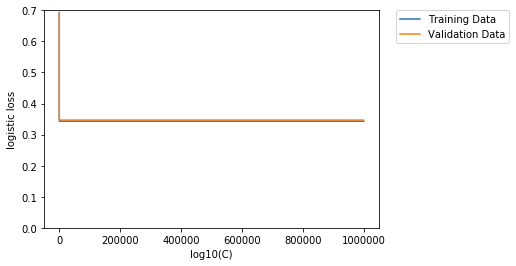

In [16]:
def x_y_corr(model_tuples):
    ''' Return x and y coordinates from a list of tuples to plot using matplotlib
       
    Args
    ----
    model_arr: 2D array containing inverse penalty (C) vs. logistic loss data for a model
        
    Returns
    -------
    corr: x and y coordinates to be returned in a matplotlib friendly fashion
    
    '''
    x_corr = []
    y_corr = []
    corr = []
    for i in range(len(model_tuples)):
        x_corr.append(model_tuples[i][0])
        y_corr.append(model_tuples[i][1])
    corr.append(x_corr)
    corr.append(y_corr)
    return corr

corr_tr = x_y_corr(tr_c_vs_loss_tuples)
corr_va = x_y_corr(va_c_vs_loss_tuples)
plt.xlabel('log10(C)');
plt.ylabel('logistic loss');
plt.ylim([0.0, 0.7]);
plt.plot(corr_tr[0], corr_tr[1], label="Training Data");
plt.plot(corr_va[0], corr_va[1], label="Validation Data")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

print("Best C-value for LR with 2-feature data: %.3f" % va_c_vs_loss_tuples[0][0]) # TODO
print("Validation set log-loss at best C-value: %.4f" % va_c_vs_loss_tuples[0][1])

#### (b) Plot the performance of the predictions made by the best classifier from step (a) on the validation set.

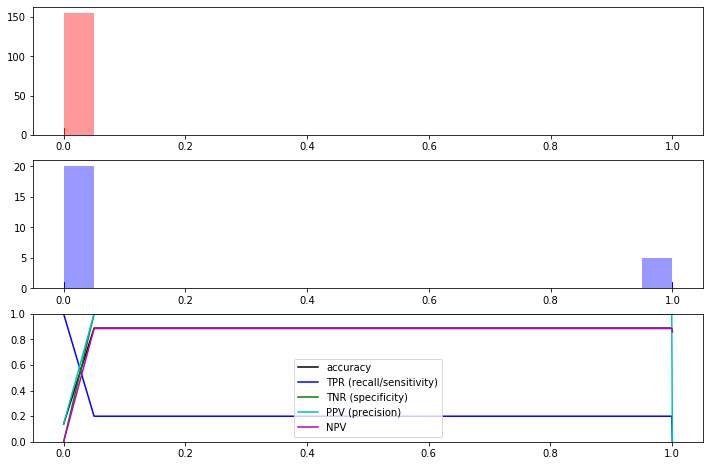

In [17]:
def get_y_prob(input_set, output_set, c):
    ''' Returns predicted output set for input set x, with inverse penalty c
       
    Args
    ----
    input_set: two or three feature cancer data 
    output_set: 1D array representing 0 (if no cancer), or 1, if cancer is present
    c: inverse penalty (float)
    Returns
    -------
    y_pred: predicted output set for an input x
    
    '''
    logreg = LogisticRegression(C=c, solver='liblinear')
    logreg.fit(input_set, output_set)
    y_pred = logreg.predict(input_set)
    return y_pred

y_pred = get_y_prob(x_va_N2, y_va_N, va_c_vs_loss_tuples[0][0])
make_plot_perf_vs_threshold(y_va_N, y_pred)

#### (c) Model fitting with 3-feature data

Repeat the model generation from **1.4 (a)**, using the full 3-feature data.

In [18]:
tr_loss_3f_list = list()
va_loss_3f_list = list()
te_loss_3f_list = list()

# dictionaries to hold values of C for parameter tuning vs the logistic loss 
# that each value of C gives for a specific input set
tr_c_vs_loss_3f_dict = {}
va_c_vs_loss_3f_dict = {}
te_c_vs_loss_3f_dict = {}

def log_reg_three_features(input_set, output_set, loss_list, model_dict):
    ''' Performs logistic regression on two feature data
       
    Args
    ----
    input_set: three feature cancer data 
    output_set: 1D array representing 0 (if no cancer), or 1, if cancer is present
    loss_list: list structure to contain values of logistic loss for different instances of c, the inverse penalty
    model_dict: dictionary structure to contain data of c vs. logistic loss for a given model
    
    Returns
    -------
    model_tuples: a tuple containing coordinates to be plotted representing c vs. logistic loss for a model 
    
    '''
    C_grid = np.logspace(-9, 6, 31)
    for c in C_grid:
        logreg = LogisticRegression(C=c, solver='liblinear')
        logreg.fit(input_set, output_set)
        prob_float = logreg.predict_proba(input_set)
        logloss = log_loss(output_set, prob_float)
        loss_list.append(logloss)
        model_dict[c] = logloss
        
    model_tuples = sorted(model_dict.items(), key=lambda x: x[1])
    return model_tuples
 
tr_c_vs_loss_3f_tuples = log_reg_three_features(x_tr_M3, y_tr_M, tr_loss_3f_list, tr_c_vs_loss_3f_dict)
va_c_vs_loss_3f_tuples = log_reg_three_features(x_va_N3, y_va_N, va_loss_3f_list, va_c_vs_loss_3f_dict)
te_c_vs_loss_3f_tuples = log_reg_three_features(x_te_N3, y_te_N, te_loss_3f_list, te_c_vs_loss_3f_dict)

#### Plot logistic loss (y-axis) vs. C (x-axis) for the 3-feature classifiers on the training set and validation set.

Again, the best values for `C` and the loss should be printed.

Best C-value for LR with 2-feature data: 1000000.000
Validation set log-loss at best C-value: 0.2577


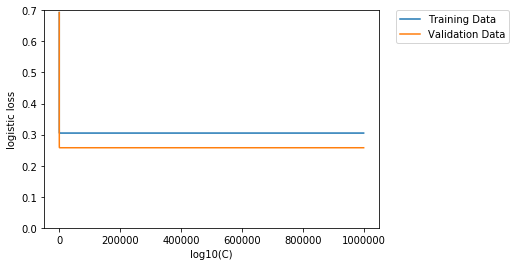

In [19]:
corr_tr_3f = x_y_corr(tr_c_vs_loss_3f_tuples)
corr_va_3f = x_y_corr(va_c_vs_loss_3f_tuples)
plt.xlabel('log10(C)');
plt.ylabel('logistic loss');
plt.ylim([0.0, 0.7]);
plt.plot(corr_tr_3f[0], corr_tr_3f[1], label="Training Data");
plt.plot(corr_va_3f[0], corr_va_3f[1], label="Validation Data")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

print("Best C-value for LR with 2-feature data: %.3f" % va_c_vs_loss_3f_tuples[0][0]) 
print("Validation set log-loss at best C-value: %.4f" % va_c_vs_loss_3f_tuples[0][1])

#### Plot the performance of the predictions made by the best 3-valued classifier on the validation set.

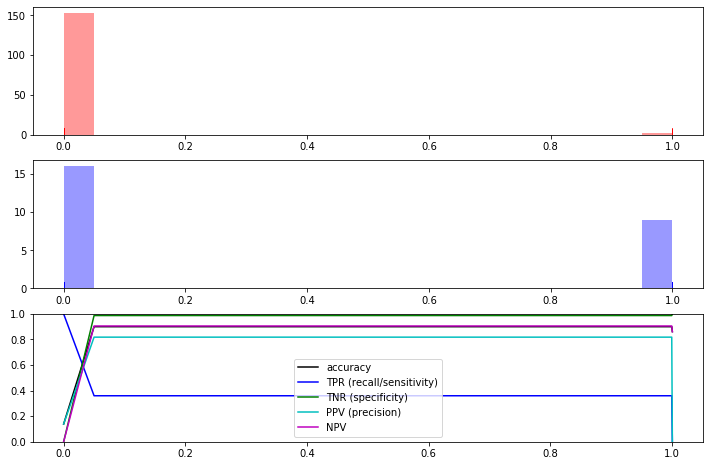

In [20]:
y_pred = get_y_prob(x_va_N3, y_va_N, va_c_vs_loss_3f_tuples[0][0])
make_plot_perf_vs_threshold(y_va_N, y_pred)

### 1.5: ROC Curves

These curves allow us to compare model performance in terms of trade-offs between false positive and true positive results.

#### (a) Plot ROC curves on the validation set.

There should be two curves in the plot, one for each of the best two classifiers from prior steps.

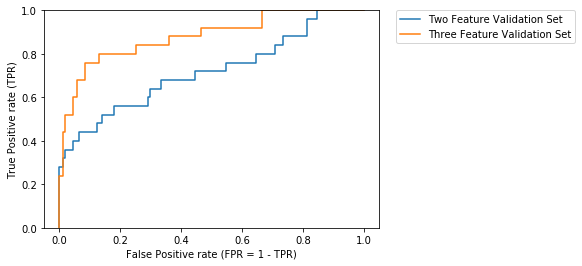

In [21]:
def get_y_prob(input_set, output_set, c):
    ''' Returns probability of a positive label in the output set for input set x, with best inverse penalty c
       
    Args
    ----
    input_set: two or three feature cancer data 
    output_set: 1D array representing 0 (if no cancer), or 1, if cancer is present
    c: inverse penalty (float)
    Returns
    -------
    y_prob: (1D array) probability for an input x that an output is positive
    
    '''
    logreg = LogisticRegression(C=c, solver='liblinear')
    logreg.fit(input_set, output_set)
    y_prob = logreg.predict_proba(input_set)
    y_prob = y_prob[:,1]
    return y_prob

y_prob_validation_2f = get_y_prob(x_va_N2, y_va_N, va_c_vs_loss_tuples[0][0])
y_prob_validation_3f = get_y_prob(x_va_N3, y_va_N, va_c_vs_loss_3f_tuples[0][0])
va_2f_fpr, va_2f_tpr, va_2f_thr = sklearn.metrics.roc_curve(y_va_N, y_prob_validation_2f)
va_3f_fpr, va_3f_tpr, va_3f_thr = sklearn.metrics.roc_curve(y_va_N, y_prob_validation_3f)

plt.ylim([0, 1]);
plt.xlabel("False Positive rate (FPR = 1 - TPR)");
plt.ylabel("True Positive rate (TPR)");
plt.plot(va_2f_fpr, va_2f_tpr, label='Two Feature Validation Set')
plt.plot(va_3f_fpr, va_3f_tpr, label='Three Feature Validation Set')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

#### (b) Plot ROC curves on the test set.

There should be two curves in the plot, one for each of the best two classifiers from prior steps.

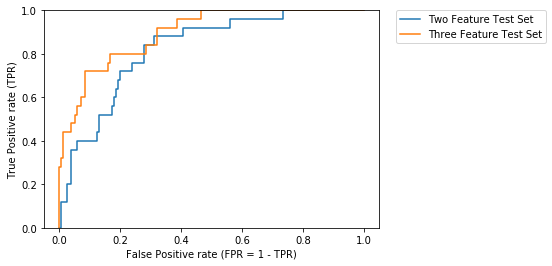

In [22]:
y_prob_test_2f = get_y_prob(x_te_N2, y_te_N, te_c_vs_loss_tuples[0][0])
y_prob_test_3f = get_y_prob(x_te_N3, y_te_N, te_c_vs_loss_3f_tuples[0][0])
te_2f_fpr, te_2f_tpr, te_2f_thr = sklearn.metrics.roc_curve(y_te_N, y_prob_test_2f)
te_3f_fpr, te_3f_tpr, te_3f_thr = sklearn.metrics.roc_curve(y_te_N, y_prob_test_3f)

plt.ylim([0, 1]);
plt.xlabel("False Positive rate (FPR = 1 - TPR)");
plt.ylabel("True Positive rate (TPR)");
plt.plot(te_2f_fpr, te_2f_tpr, label='Two Feature Test Set')
plt.plot(te_3f_fpr, te_3f_tpr, label='Three Feature Test Set')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

#### (c) Analyze the results shown in both the above plots, to compare classifier performance.

**Answer**: It is clear that for this binary classifier, the three feature set for both validation and test sets has better performance than the two feature input set. One can gather this from determining the Area Under the Curve (AUC) visually between both models, under the curves. For both the test set and the validation set, the area under the curve for the three feature input set is lower than that of the three feature input set. This means that the three feature input set, in both instances, allows for less false positives for each true positive, making the three feature input set rank higher than the two feature input set, in terms of performance. An ideal classifier would have a line from FPR = 0 and TPR = 0 to FPR = 0 to TPR = 1.0, (0.0, 0.0) to (0.0, 1.0), which would suggest that the model has no false positives per true negative, suggesting a very accurate model. Comparing the two input sets, the validation set and the test set, it can be seen that the test set has better performance than the validation set in the two feature and three feature models, which can be explained: the vaidation set is used to adjust (validate) the weights being used in both models, which means that it is being used to minimize overfitting. It matters more that the testing set has better performance in terms of ROC because the testing set is what is used to confirm the how well the model predicts; the validation set is used to tune the model and minimize overfitting.

### 1.6: Selecting a decision threshold

#### (a) Using default 0.5 threshold. 

Generate a confusion matrix for the best 3-feature logistic model on the test set, using threshold 0.5.

In [23]:
best_thr = 0.5


print("ON THE VALIDATION SET:")
print("Chosen best thr = %.4f" % best_thr)
print("")
print("ON THE TEST SET:")
print(calc_confusion_matrix_for_threshold(y_te_N, y_prob_test_3f, best_thr))
print("")
print(print_perf_metrics_for_threshold(y_te_N, y_prob_test_3f, best_thr))

ON THE VALIDATION SET:
Chosen best thr = 0.5000

ON THE TEST SET:
Predicted    0   1
True              
0          149   6
1           14  11

0.889 ACC
0.440 TPR
0.961 TNR
0.647 PPV
0.914 NPV
None


#### (b) Pick a threshold to maximize TPR, while ensuring PPV >= 0.98.

After finding the best threshold on the validation set, plot its confusion matrix and print its various performance metrics, for the test set.

In [24]:
thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(y_va_N, y_prob_validation_3f)

def maximize_key_1(threshold_grid, performance_dict, key_1, key_2, threshold):
    ''' Mazimizes the value for a given key_1 in the performance dictionary returned
    by compute_perf_metrics_acroos_thresholds, while ensuring the corresponding 
    value for the given key_2 in the performance dictionary is at a certain threshold
    
       
    Args
    ----
    threshold_grid: 1D array of floats returned by compute_perf_metrics_across_thresholds
    performance_dict: performance dictionary returned by compute_perf_metrics_across_thresholds
    key_1: 'acc' (accuracy), 'ppv' (positive predictive values), 'npv' (negative predictive values),
           'tpr' (true positive rates), or 'tnr' (true negative rates)
    key_2: 'acc' (accuracy), 'ppv' (positive predictive values), 'npv' (negative predictive values),
           'tpr' (true positive rates), or 'tnr' (true negative rates)  
    threshold: float representing threshold for key_2
    Returns
    -------
    thres: threshold that maximizes output of key_1, while maintaining key_2
    
    '''
    thres = 0.0
    max_key_1 = float('-inf')
    for i in range(len(threshold_grid)):
        if (performance_dict[key_1][i] > max_key_1) and (performance_dict[key_2][i] >= threshold):
            max_key_1 = performance_dict[key_1][i]
            thres = threshold_grid[i]
    return thres
  
best_thr = maximize_key_1(thresh_grid, perf_grid, 'tpr', 'ppv', 0.98)
print("ON THE VALIDATION SET:")
print("Chosen best thr = %.4f" % best_thr)
print("")
print("ON THE TEST SET:")
print(calc_confusion_matrix_for_threshold(y_te_N, y_prob_test_3f, best_thr))
print("")
print(print_perf_metrics_for_threshold(y_te_N, y_prob_test_3f, best_thr))

ON THE VALIDATION SET:
Chosen best thr = 0.7302

ON THE TEST SET:
Predicted    0  1
True             
0          155  0
1           18  7

0.900 ACC
0.280 TPR
1.000 TNR
1.000 PPV
0.896 NPV
None


#### (c) Pick a threshold to maximize PPV, while ensuring TPR >= 0.98.

After finding the best threshold on the validation set, plot its confusion matrix and print its various performance metrics, for the test set.

In [25]:
thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(y_va_N, y_prob_validation_3f)
best_thr = maximize_key_1(thresh_grid, perf_grid, 'ppv', 'tpr', 0.98)
print("ON THE VALIDATION SET:")
print("Chosen best thr = %.4f" % best_thr) # TODO
print("")
print("ON THE TEST SET:")
print(calc_confusion_matrix_for_threshold(y_te_N, y_prob_test_3f, best_thr))
print("")
print(print_perf_metrics_for_threshold(y_te_N, y_prob_test_3f, best_thr))

ON THE VALIDATION SET:
Chosen best thr = 0.0186

ON THE TEST SET:
Predicted   0   1
True             
0          73  82
1           0  25

0.544 ACC
1.000 TPR
0.471 TNR
0.234 PPV
1.000 NPV
None


#### (d) Compare the confusion matrices from (a)–(c) to analyze the different thresholds.

**Answer**: For the confusion matrix in subproblem (a), a default threshold of 0.5 was used, which resulted in a TPR of .440, a TNR of .961, a FPR (false positive rate) of .039, and a FNR (false negative rate) of .56. For the confusion matrix in subproblem (b), TPR was maximized while PPV >= .98. This resulted in a chosen best threshold of .7302, which resulted in a TPR of .280, a TNR of 1.0, a FPR of 0, and a FNR of .72. For the confusion matrix in subproblem (c), where PPV was maximized while TPR >= .98, in which the best threshold is .0186, the TPR is 1.0, the TNR is .471, the FPR is .53, and the FNR is 0. The false positive rate is a type 1 error, and the false negative rate is a type 2 error. The cost that matters the most in these three cases is the false negative rate, a type 2 error which means a patient is falsely predicted to not have cancer when they do actually have it. This metric must be as low as possible, while the type 1 error (the False Positive Rate, FPR) is also as low as possible to avoid unnecessary biopsies. Since the cost of the type 2 error of not predicting cancer (FNR) is more severe than the cost of the type 1 error (FPR) of an unnecessary biopsy, the best threshold is the one that minimizes FNR first. In this case, this would be the threshold generated when PPV was maximized, while ensuring that TPR >= .98, in subproblem (c). The FNR in this case was 0, which matters more than the relatively high FPR of .53. Thus, the best threshold here is .0186.

#### (e) How many biopsies can be avoided using the best threshold for the classifier?

**Answer**: If we were to hold the cost of a type 2 error higher than that of a type 1 error, as in the case above in subproblem (e), than the model that maximizes PPV while ensuring TPR >= .98 provides the best threshold of .0186. If this classifier were used by the hospital, the FPR would be .53, which means 1-FPR biopsies could be avoided, which is 47% of all biopsies.

## Part Two: Abalone Age

### 2.1: Build k-neighor regression models.

Your code should load the abalone data, and build a sequence of nearest neighbor models for it.  For each model, the MSE on the various input sets should be determined.

In [26]:
k_grid = [1, 3, 5, 7, 9, 11, 21, 41, 61, 81, 101, 201, 401, 801]

# load feature data
x_tr_ab = np.loadtxt('./data_abalone/x_train.csv', delimiter=',', skiprows=1)
x_va_ab = np.loadtxt('./data_abalone/x_valid.csv', delimiter=',', skiprows=1)
x_te_ab = np.loadtxt('./data_abalone/x_test.csv', delimiter=',', skiprows=1)

# load output data
y_tr_ab = np.loadtxt('./data_abalone/y_train.csv', delimiter=',', skiprows=1)
y_va_ab = np.loadtxt('./data_abalone/y_valid.csv', delimiter=',', skiprows=1)
y_te_ab = np.loadtxt('./data_abalone/y_test.csv', delimiter=',', skiprows=1)

def run_k_neighbors_and_calc_mse(k_grid, input_set, output_set):
    ''' Builds k-neighbors regression models and calculates mean squared error
    for various values of k, on abalone data
       
    Args
    ----
    k_grid: 1D array of ints representing values of k
    input_set: n-dimensional feature data for abalone 
    output_set: 1D data (y_true) representing the number of rings an abalone has
    Returns
    -------
    mse: 1D array of floats representing the mean_squared_error for the input set
    and the predicted model for a certain value of k
    
    '''
    
    mse = []
    y_pred = []
    for i in range(len(k_grid)):
        neigh = KNeighborsRegressor(n_neighbors= k_grid[i])
        neigh.fit(x_tr_ab, y_tr_ab)
        y_pred = neigh.predict(input_set)
        mean_squared = mean_squared_error(output_set, y_pred)  
        mse.append(mean_squared)
    return mse
        
mse_validation = run_k_neighbors_and_calc_mse(k_grid, x_va_ab, y_va_ab)
mse_testing = run_k_neighbors_and_calc_mse(k_grid, x_te_ab, y_te_ab)        

### 2.2: Plot the MSE.

Your code should plot the mean squared error on the test and validation sets, for each of the settings of the number of neighbors.

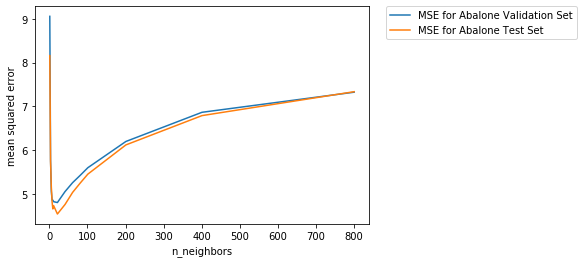

In [27]:
plt.xlabel('n_neighbors');
plt.ylabel('mean squared error');

plt.plot(k_grid, mse_validation, label='MSE for Abalone Validation Set')
plt.plot(k_grid, mse_testing, label='MSE for Abalone Test Set')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


### 2.3: Determine best overall model.

In [28]:
def determine_minimal_error(mse_array, k_grid):
    ''' Finds best possible k value by determining the lowest possible mean squared error for 
        a k-neighbors model
       
    Args
    ----
    mse_array: 1D array of floats representing mean squared error for values of k in k_grid, respectively
    k_grid: 1D array representing possible values of k
    
    Returns
    -------
    best_k_val: the best possible k_val with the lowest possible mean squared error, as determined in the 
    mse_array
    
    '''
    min_mse = float('inf')
    best_k_val = 0
    for i in range(len(k_grid)):
        if mse_array[i] < min_mse:
            min_mse = mse_array[i]
            best_k_val = k_grid[i]
    return best_k_val

def pretty_print_mse_at_optimal_k(k, input_set, output_set, data_label):
    neigh = KNeighborsRegressor(n_neighbors= k)
    neigh.fit(x_tr_ab, y_tr_ab)
    y_pred = neigh.predict(input_set)
    mean_squared = mean_squared_error(output_set, y_pred)  
    print("The mean-squared error for the " + data_label + " set is %f" % mean_squared + " at n-neighbors = %d" % k)
    
            
print("The minimal error model on the validation set has n_neighbors = %d" % determine_minimal_error(mse_validation, k_grid)) # TODO: fix
pretty_print_mse_at_optimal_k(determine_minimal_error(mse_validation, k_grid), x_tr_ab, y_tr_ab, "training")
pretty_print_mse_at_optimal_k(determine_minimal_error(mse_validation, k_grid), x_te_ab, y_te_ab, "testing")
pretty_print_mse_at_optimal_k(determine_minimal_error(mse_validation, k_grid), x_va_ab, y_va_ab, "validation")

The minimal error model on the validation set has n_neighbors = 21
The mean-squared error for the training set is 4.384234 at n-neighbors = 21
The mean-squared error for the testing set is 4.542798 at n-neighbors = 21
The mean-squared error for the validation set is 4.804739 at n-neighbors = 21
